<a href="https://colab.research.google.com/github/zhangjx831/Multilingual-Speech-Emotion-Recognition-System/blob/Luwei/EmoDB%20EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2022 (German) EmoDB Exploration**

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [5]:
import librosa
import librosa.display
from IPython.display import Audio

## get a sample to visualize

In [6]:
SAMPLE_FILE = 'drive/MyDrive/EmoDB/03a01Fa.wav'

# load the audio file to get the sample
samples, sample_rate = librosa.load(SAMPLE_FILE, sr = None)

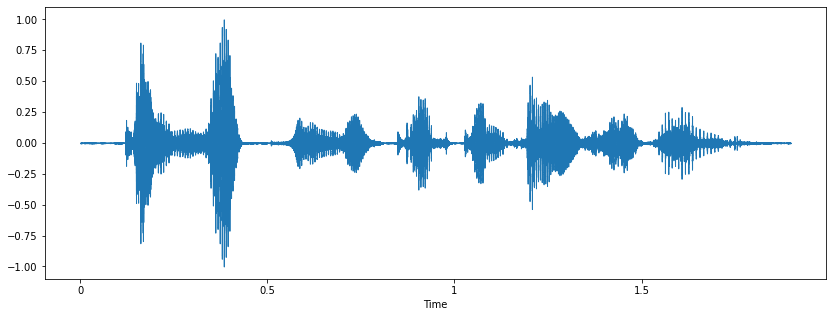

In [7]:
# visualize the sound wave
plt.figure(figsize = (14, 5))
librosa.display.waveshow(samples, sr = sample_rate)

In [8]:
# play the audio directly
Audio(SAMPLE_FILE)

In [9]:
print ('Sample shape ', samples.shape, 'Sample rate ', sample_rate, 'Data type', type(samples))

Sample shape  (30372,) Sample rate  16000 Data type <class 'numpy.ndarray'>


/usr/local/lib/python3.7/dist-packages/librosa/display.py:955: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  "Trying to display complex-valued input. " "Showing magnitude instead."


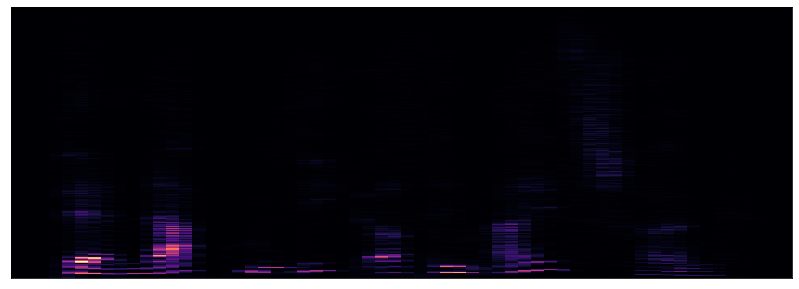

In [10]:
# Spectrograms: plot frequency vs time to indicate the Amplitude of each frequency
plt.figure(figsize = (14, 5))
sgram = librosa.stft(samples)
librosa.display.specshow(sgram)

<Figure size 1008x360 with 0 Axes>

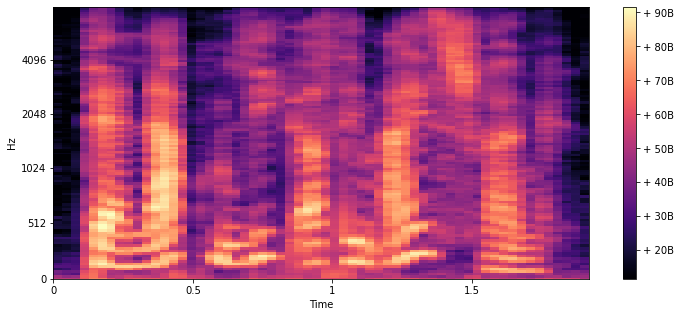

In [11]:
# Modify the to use Mel Scale (a scale of pitches, s.t. each unit is judged by listeners to be equal in pitches distance from the next) instead of Frequency
plt.figure(figsize = (14, 5))
sgram_mag, _ = librosa.magphase(sgram)
mel_scale_sgram = librosa.feature.melspectrogram(S = sgram_mag, sr = sample_rate)
# use the decibel scale to get the final Mel Spectrogram
plt.figure(figsize = (12, 5))
mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
librosa.display.specshow(mel_sgram, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='+% dB')

## Overall explortaion

In [12]:
path = 'drive/MyDrive/EmoDB'
entries = os.listdir(path)

In [13]:
emotion_counter = dict()
emotions = {
    'W': 'anger',
    'L': 'boredom',
    'E': 'disgust',
    'A': 'anxiety/fear',
    'F': 'happiness',
    'T': 'sadness',
    'N': 'neutral version'
}

for entry in entries:
    emo = emotions[entry[5]]
    # emo = entry[5]
    if emo not in emotion_counter:
        emotion_counter[emo] = 0
    emotion_counter[emo] += 1

In [14]:
print(f'Total sample number: {len(entries)}')
print(f'Distinct emotion number: {len(emotion_counter)}\n')
print("------ Sample numbers ------")
for emo in emotion_counter:
    print(f'{emo}: {emotion_counter[emo]}')

Total sample number: 535
Distinct emotion number: 7

------ Sample numbers ------
happiness: 71
neutral version: 79
anger: 127
sadness: 62
anxiety/fear: 69
boredom: 81
disgust: 46


In [15]:
# create a dataframe to store filename with its category
df = pd.DataFrame({'fileName': entries})
df['Category'] = df.apply(lambda row: row[0][5], axis=1)

In [16]:
df

,fileName,Category
0,03a01Fa.wav,F
1,03a01Nc.wav,N
2,03a01Wa.wav,W
3,03a02Fc.wav,F
4,03a02Nc.wav,N
...,...,...
530,16b09Ab.wav,A
531,16b03Wb.wav,W
532,16b09Fb.wav,F
533,16b10Wb.wav,W


In [17]:
df['audio_len'] = 0
df['sample_rate'] = 0

In [18]:
for i in range(len(df)):
  entry = df.iloc[i,0]
  file_path = path +'/'+ entry
  sample, sample_rate = librosa.load(file_path, sr = None)
  df.iloc[i,2] = len(sample)
  df.iloc[i,3] = sample_rate

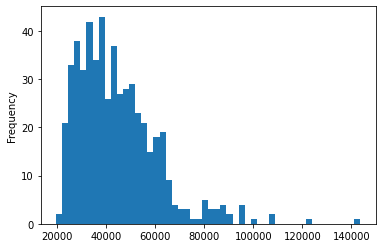

In [19]:
df['audio_len'].plot.hist(bins = 50) #(bins=12, alpha=0.5)

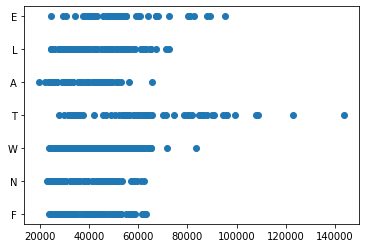

In [20]:
plt.plot(df['audio_len'], df['Category'], 'o')

## Some ML classifiers

In [21]:
max_len = df.audio_len.max()
X = np.zeros([len(df), max_len])
y = []

emotion_index = {
    'W': 1,
    'L': 2,
    'E': 3,
    'A': 4,
    'F': 5,
    'T': 6,
    'N': 7
}


for i in range(len(df)):
  entry = df.iloc[i,0]
  aud_len = df.iloc[i,2]

  file_path = path +'/'+ entry
  sample, sample_rate = librosa.load(file_path, sr = None)
  
  X[i,:aud_len] = sample
  y.append(emotion_index[df.iloc[i,1]])

y = np.array(y)

### SVM

In [22]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [23]:
clf = svm.SVC(C=1, kernel = 'rbf', decision_function_shape = 'ovo')
clf.fit(X_train, y_train)

SVC(C=1, decision_function_shape='ovo')

[[28  1  0  0  0  0  0]
 [ 8 13  0  0  0  1  0]
 [ 7  1  0  0  0  0  0]
 [13  4  0  0  0  0  0]
 [19  1  0  0  0  0  0]
 [ 3  8  0  0  0  3  0]
 [18  6  0  0  0  0  0]]


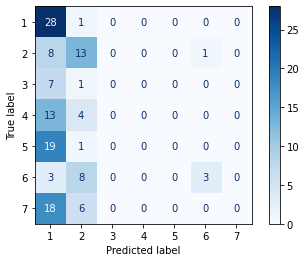

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_estimator(
    clf,
    X_test,
    y_test,
    #display_labels=y.unique(),
    cmap=plt.cm.Blues
)
print(disp.confusion_matrix)

In [25]:
clf.score(X_test,y_test)

0.3283582089552239

### Tree based models

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
gbc = LGBMClassifier(random_state = 42)
gbc.fit(X_train, y_train)

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
    gbc,
    X_test,
    y_test,
    #display_labels=y.unique(),
    cmap=plt.cm.Blues
)
print(disp.confusion_matrix)

In [ ]:
gbc.score(X_test,y_test)

### KNN

In [26]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

[[29  0  0  0  0  0  0]
 [22  0  0  0  0  0  0]
 [ 8  0  0  0  0  0  0]
 [17  0  0  0  0  0  0]
 [20  0  0  0  0  0  0]
 [14  0  0  0  0  0  0]
 [24  0  0  0  0  0  0]]


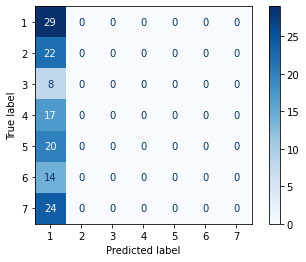

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_estimator(
    neigh,
    X_test,
    y_test,
    #display_labels=y.unique(),
    cmap=plt.cm.Blues
)
print(disp.confusion_matrix)

In [27]:
neigh.score(X_test,y_test)

0.21641791044776118